# Introduction to 2D Elliptic Equations (Poisson / Laplace)

This notebook demonstrates how to build a finite-difference discretization for the 2D Laplace/Poisson equation on a rectangular domain, how to assemble the sparse linear system using the `elliptic` module (from `02-Elliptic-Equations/src`), and how to solve it with direct and iterative methods. We compare timings and accuracy and show visualization of the solutions.

**Run from repository root** or adjust paths accordingly.

In [10]:
# Setup paths for imports
import sys
from pathlib import Path

# Get repository root (notebook is in 02-Elliptic-Equations/notebooks/)
repo_root = Path.cwd()
if 'notebooks' in str(Path.cwd()):
    repo_root = Path.cwd().parent.parent
    
sys.path.insert(0, str(repo_root / '02-Elliptic-Equations' / 'src'))

# Standard imports
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Import the elliptic helpers we created
from elliptic import build_poisson_2d, solve_direct, solve_cg, jacobi, sor

---
## Part 1: Simple Example - Laplace Equation with Dirichlet BC

**Problem**: Solve $\nabla^2 u = 0$ on $[0,1] \times [0,1]$ with:
- $u = 0$ on left, right, and bottom edges
- $u = 1$ on top edge

This represents steady-state temperature in a plate with bottom/sides at 0°C and top at 1°C.

In [11]:
# Define problem parameters
nx, ny = 31, 31  # Grid points (including boundaries)
lx, ly = 1.0, 1.0  # Domain size

# Boundary conditions: Dirichlet on all edges
bc = {
    'left': ('dirichlet', 0.0),
    'right': ('dirichlet', 0.0),
    'bottom': ('dirichlet', 0.0),
    'top': ('dirichlet', 1.0)  # Hot edge
}

# Build the discrete system
print("Building discrete Poisson system...")
A, b, (nx_out, ny_out, hx, hy) = build_poisson_2d(nx, ny, lx, ly, bc=bc)

print(f"Grid: {nx} × {ny} = {nx*ny} total points")
print(f"Interior unknowns: {(nx-2)} × {(ny-2)} = {A.shape[0]}")
print(f"Matrix sparsity: {A.nnz} non-zeros ({100*A.nnz/A.shape[0]**2:.2f}% dense)")
print(f"Grid spacing: hx = {hx:.4f}, hy = {hy:.4f}")

Building discrete Poisson system...
Grid: 31 × 31 = 961 total points
Interior unknowns: 29 × 29 = 841
Matrix sparsity: 4089 non-zeros (0.58% dense)
Grid spacing: hx = 0.0333, hy = 0.0333


### Solve using Direct Method

In [12]:
# Solve with direct sparse solver
t0 = time.time()
u_interior = solve_direct(A, b)
t_direct = time.time() - t0

print(f"Direct solver: {t_direct:.4f} seconds")
print(f"Solution range: [{u_interior.min():.6f}, {u_interior.max():.6f}]")

# Reconstruct full solution with boundaries
u_full = np.zeros((ny, nx))
u_full[1:-1, 1:-1] = u_interior.reshape((ny-2, nx-2))
# Apply boundary conditions
u_full[-1, :] = 1.0  # Top edge
# Left, right, bottom already zero from initialization

Direct solver: 0.0025 seconds
Solution range: [0.001217, 0.932833]


### Visualization

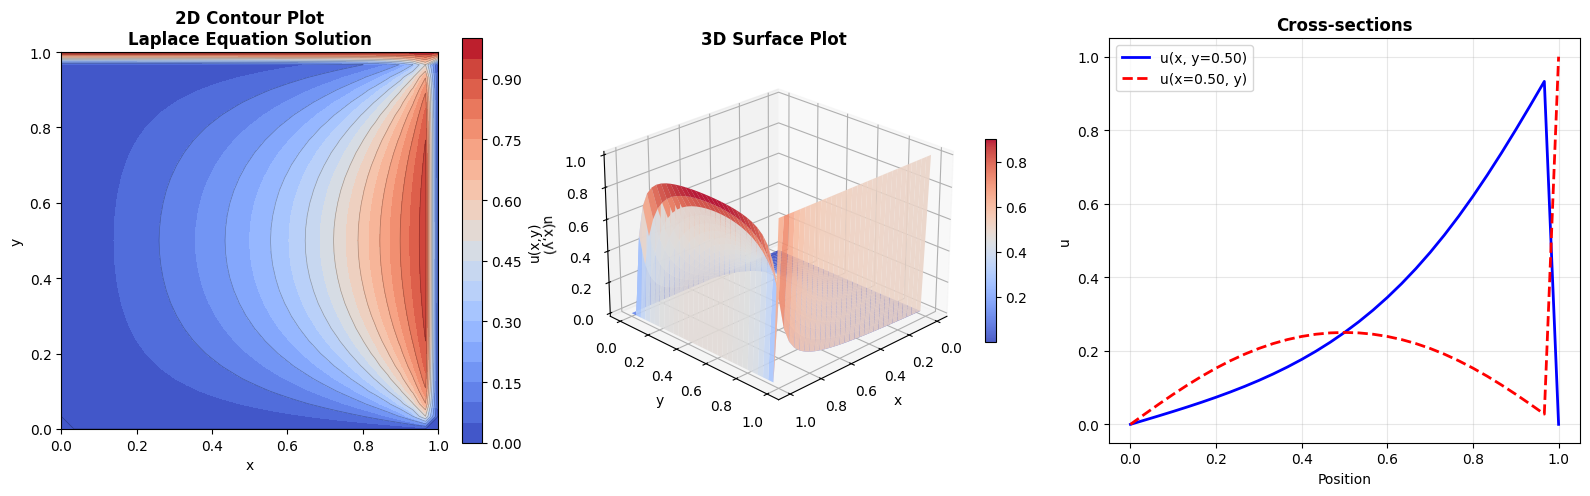

✅ Solution shows smooth transition from u=0 (bottom) to u=1 (top)


In [13]:
# Create visualization
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(16, 5))

# 2D contour plot
ax1 = fig.add_subplot(131)
contour = ax1.contourf(X, Y, u_full, levels=20, cmap='coolwarm')
ax1.contour(X, Y, u_full, levels=10, colors='k', alpha=0.3, linewidths=0.5)
plt.colorbar(contour, ax=ax1, label='u(x,y)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('2D Contour Plot\nLaplace Equation Solution', fontsize=12, weight='bold')
ax1.set_aspect('equal')

# 3D surface plot
ax2 = fig.add_subplot(132, projection='3d')
surf = ax2.plot_surface(X, Y, u_full, cmap='coolwarm', edgecolor='none', alpha=0.9)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')
ax2.set_title('3D Surface Plot', fontsize=12, weight='bold')
ax2.view_init(elev=25, azim=45)
plt.colorbar(surf, ax=ax2, shrink=0.5)

# Cross-section at y = 0.5
ax3 = fig.add_subplot(133)
mid_idx = ny // 2
ax3.plot(x, u_full[mid_idx, :], 'b-', linewidth=2, label=f'u(x, y={y[mid_idx]:.2f})')
ax3.plot(x, u_full[:, nx//2].T, 'r--', linewidth=2, label=f'u(x={x[nx//2]:.2f}, y)')
ax3.grid(True, alpha=0.3)
ax3.set_xlabel('Position')
ax3.set_ylabel('u')
ax3.set_title('Cross-sections', fontsize=12, weight='bold')
ax3.legend()

plt.tight_layout()
plt.show()

print("✅ Solution shows smooth transition from u=0 (bottom) to u=1 (top)")

---
## Part 2: Comparison of Solution Methods

Let's compare different methods for solving the same problem:
- **Direct**: Sparse LU factorization (exact, but expensive for large problems)
- **Conjugate Gradient (CG)**: Iterative Krylov method (fast for large problems)
- **Jacobi**: Simple iterative method (slow convergence)
- **SOR (Successive Over-Relaxation)**: Accelerated Jacobi (better convergence)

In [14]:
# Test on larger grid
nx_test, ny_test = 101, 101

# Define boundary conditions for this test
bc_test = {
    'left': ('dirichlet', 0.0),
    'right': ('dirichlet', 0.0),
    'bottom': ('dirichlet', 0.0),
    'top': ('dirichlet', 1.0)
}

A_test, b_test, _ = build_poisson_2d(nx_test, ny_test, bc=bc_test)

print(f"Test problem: {nx_test} × {ny_test} grid, {A_test.shape[0]:,} unknowns\n")

# Direct solver
print("1. Direct solver (sparse LU)...")
t0 = time.time()
u_direct = solve_direct(A_test, b_test)
t_direct = time.time() - t0
print(f"   Time: {t_direct:.4f} s")

# Conjugate Gradient
print("\n2. Conjugate Gradient (CG) with Jacobi preconditioner...")
t0 = time.time()
u_cg, info_cg = solve_cg(A_test, b_test, tol=1e-8)
t_cg = time.time() - t0
print(f"   Time: {t_cg:.4f} s")
print(f"   Iterations: {info_cg.get('iterations', 'N/A')}")
print(f"   Error vs direct: {np.linalg.norm(u_cg - u_direct)/np.linalg.norm(u_direct):.2e}")

# Jacobi iteration
print("\n3. Jacobi iteration...")
t0 = time.time()
u_jac, iter_jac, res_jac = jacobi(A_test, b_test, tol=1e-8, maxiter=5000)
t_jac = time.time() - t0
print(f"   Time: {t_jac:.4f} s")
print(f"   Iterations: {iter_jac}")
print(f"   Error vs direct: {np.linalg.norm(u_jac - u_direct)/np.linalg.norm(u_direct):.2e}")

# SOR (Successive Over-Relaxation)
print("\n4. SOR (ω = 1.5)...")
t0 = time.time()
u_sor, iter_sor, res_sor = sor(A_test, b_test, omega=1.5, tol=1e-8, maxiter=5000)
t_sor = time.time() - t0
print(f"   Time: {t_sor:.4f} s")
print(f"   Iterations: {iter_sor}")
print(f"   Error vs direct: {np.linalg.norm(u_sor - u_direct)/np.linalg.norm(u_direct):.2e}")

print("\n" + "="*60)
print("Summary: Method Comparison")
print("="*60)
print(f"{'Method':<20} {'Time (s)':<12} {'Speedup'}")
print("-"*60)
print(f"{'Direct (baseline)':<20} {t_direct:<12.4f} 1.00×")
print(f"{'CG':<20} {t_cg:<12.4f} {t_direct/t_cg:.2f}×")
print(f"{'Jacobi':<20} {t_jac:<12.4f} {t_direct/t_jac:.2f}×")
print(f"{'SOR':<20} {t_sor:<12.4f} {t_direct/t_sor:.2f}×")

Test problem: 101 × 101 grid, 9,801 unknowns

1. Direct solver (sparse LU)...
   Time: 0.0580 s

2. Conjugate Gradient (CG) with Jacobi preconditioner...
   Time: 0.0331 s
   Iterations: N/A
   Error vs direct: 2.79e-05

3. Jacobi iteration...
   Time: 0.3374 s
   Iterations: 5000
   Error vs direct: 4.80e-02

4. SOR (ω = 1.5)...
   Time: 140.1438 s
   Iterations: 3969
   Error vs direct: 4.69e-06

Summary: Method Comparison
Method               Time (s)     Speedup
------------------------------------------------------------
Direct (baseline)    0.0580       1.00×
CG                   0.0331       1.75×
Jacobi               0.3374       0.17×
SOR                  140.1438     0.00×


---
## Part 3: Matrix Structure Visualization

The coefficient matrix $\mathbf{A}$ has a special **sparse banded structure** that's crucial for efficient computation.

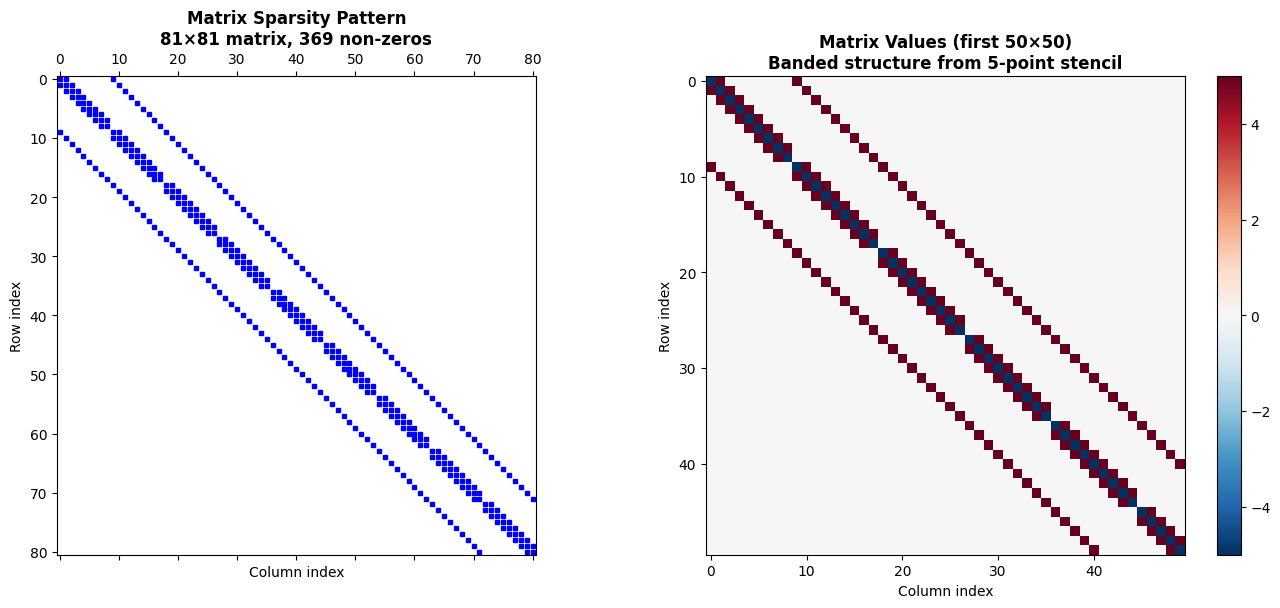

Matrix statistics:
  Shape: 81 × 81
  Non-zeros: 369 (5.624% dense)
  Bandwidth: ~9 (from grid structure)

💡 Sparse storage saves 94.4% memory!


In [15]:
# Visualize matrix structure for small problem
nx_small, ny_small = 11, 11

# Define boundary conditions for this example
bc_vis = {
    'left': ('dirichlet', 0.0),
    'right': ('dirichlet', 0.0),
    'bottom': ('dirichlet', 0.0),
    'top': ('dirichlet', 1.0)
}

A_small, b_small, _ = build_poisson_2d(nx_small, ny_small, bc=bc_vis)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Spy plot (show non-zero pattern)
axes[0].spy(A_small, markersize=3, color='blue')
axes[0].set_title(f'Matrix Sparsity Pattern\n{A_small.shape[0]}×{A_small.shape[0]} matrix, {A_small.nnz} non-zeros', 
                  fontsize=12, weight='bold')
axes[0].set_xlabel('Column index')
axes[0].set_ylabel('Row index')

# Show actual values (small subset)
n_show = min(50, A_small.shape[0])
A_dense = A_small[:n_show, :n_show].toarray()
im = axes[1].imshow(A_dense, cmap='RdBu_r', vmin=-5, vmax=5)
axes[1].set_title(f'Matrix Values (first {n_show}×{n_show})\nBanded structure from 5-point stencil', 
                  fontsize=12, weight='bold')
axes[1].set_xlabel('Column index')
axes[1].set_ylabel('Row index')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"Matrix statistics:")
print(f"  Shape: {A_small.shape[0]} × {A_small.shape[0]}")
print(f"  Non-zeros: {A_small.nnz} ({100*A_small.nnz/A_small.shape[0]**2:.3f}% dense)")
print(f"  Bandwidth: ~{ny_small-2} (from grid structure)")
print(f"\n💡 Sparse storage saves {100*(1-A_small.nnz/A_small.shape[0]**2):.1f}% memory!")

---
## Summary and Key Takeaways

### What We Learned

1. **Elliptic PDEs** describe equilibrium phenomena (electrostatics, steady heat, etc.)

2. **Finite difference discretization** converts the PDE into a large sparse linear system $\mathbf{A}\mathbf{u} = \mathbf{b}$

3. **Boundary conditions** are essential:
   - Dirichlet: specify values
   - Neumann: specify derivatives
   
4. **Solution methods** have different trade-offs:
   - Direct: accurate but slow for large problems (O(n³) or worse)
   - CG: fast iterative method for symmetric positive definite problems (O(n²) typically)
   - Jacobi/SOR: simple iterative methods (slower convergence)

5. **Matrix structure** is crucial:
   - Only ~5 non-zeros per row (5-point stencil)
   - Sparse storage saves >99% memory
   - Band structure enables efficient algorithms

### Next Steps

- **Notebook 02**: Advanced iterative solvers (line-relaxation, ADI)
- **Notebook 03**: Convergence analysis and preconditioning
- **Notebook 04**: Advanced analysis and benchmarks
- **Notebook 05**: Advanced solvers (line-relaxation, ADI)
- **Notebook 06**: Multigrid methods (O(n) complexity! 🚀)
- **Notebook 07**: Variable coefficients and heterogeneous materials

### 📚 References

- LeVeque, R. J. (2007). *Finite Difference Methods for Ordinary and Partial Differential Equations*
- Trefethen, L. N., & Bau, D. (1997). *Numerical Linear Algebra*
- Saad, Y. (2003). *Iterative Methods for Sparse Linear Systems*